In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/Research/AAAI/complexity/200_50/'

In [3]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt
%matplotlib inline

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Generate dataset

0 530
1 463
2 494
3 517
4 488
5 497
6 493
7 507
8 492
9 519


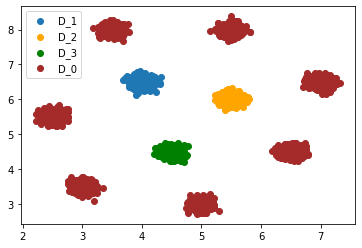

In [4]:
np.random.seed(12)
y = np.random.randint(0,10,5000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)
x = np.zeros((5000,2))
np.random.seed(12)
x[idx[0],:] = np.random.multivariate_normal(mean = [4,6.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [5.5,6],cov=[[0.01,0],[0,0.01]],size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [4.5,4.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [3,3.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [2.5,5.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [3.5,8],cov=[[0.01,0],[0,0.01]],size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [5.5,8],cov=[[0.01,0],[0,0.01]],size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [7,6.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [6.5,4.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [5,3],cov=[[0.01,0],[0,0.01]],size=sum(idx[9]))
color = ['#1F77B4','orange', 'g','brown']
name = [1,2,3,0]
for i in range(10):
  if i==3:
    plt.scatter(x[idx[i],0],x[idx[i],1],c=color[3],label="D_"+str(name[i]))
  elif i>=4:
    plt.scatter(x[idx[i],0],x[idx[i],1],c=color[3])
  else:
    plt.scatter(x[idx[i],0],x[idx[i],1],c=color[i],label="D_"+str(name[i]))
plt.legend()

In [5]:
x[idx[0]][0], x[idx[5]][5] 

(array([4.04729858, 6.43185741]), array([3.4612816 , 8.00144771]))

In [6]:
desired_num = 6000
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,9)
    a = []
    for i in range(9):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(a)
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [7]:
len(mosaic_list_of_images), mosaic_list_of_images[0]

(6000, array([[2.97319488, 3.56326392],
        [2.59779787, 5.38694546],
        [6.50095845, 4.49418185],
        [7.06459245, 6.53896691],
        [5.0161796 , 2.92679482],
        [4.1251117 , 6.62627906],
        [3.43548455, 7.98866194],
        [5.01328229, 3.05196492],
        [4.91416206, 3.02422072]]))

# load mosaic data

In [8]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list, mosaic_label,fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list
    self.label = mosaic_label
    self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] , self.fore_idx[idx]

In [9]:
batch = 250
msd1 = MosaicDataset(mosaic_list_of_images[0:3000], mosaic_label[0:3000] , fore_idx[0:3000])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

In [10]:
batch = 250
msd2 = MosaicDataset(mosaic_list_of_images[3000:6000], mosaic_label[3000:6000] , fore_idx[3000:6000])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

# models

In [11]:
class Focus_deep(nn.Module):
    '''
       deep focus network averaged at zeroth layer
       input : elemental data
    '''
    def __init__(self,inputs,output,K,d):
        super(Focus_deep,self).__init__()
        self.inputs = inputs
        self.output = output
        self.K = K
        self.d  = d
        self.linear1 = nn.Linear(self.inputs,200, bias=False)  #,self.output)
        self.linear2 = nn.Linear(200,self.output, bias=False) 

        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        
    def forward(self,z):
        batch = z.shape[0]
        x = torch.zeros([batch,self.K],dtype=torch.float64)
        y = torch.zeros([batch,200], dtype=torch.float64)   # number of features of output
        features = torch.zeros([batch,self.K,200],dtype=torch.float64)
        x,y = x.to("cuda"),y.to("cuda")
        features = features.to("cuda")
        for i in range(self.K):
            alp,ftrs = self.helper(z[:,i] )  # self.d*i:self.d*i+self.d
            x[:,i] = alp[:,0]
            features[:,i]  = ftrs 
        log_x = F.log_softmax(x,dim=1)  # log_alphas
        x = F.softmax(x,dim=1)   # alphas
        
        for i in range(self.K):
            x1 = x[:,i]          
            y = y+torch.mul(x1[:,None],features[:,i])  # self.d*i:self.d*i+self.d
        return y , x,log_x 
    def helper(self,x):
      x = self.linear1(x)
      x1 = F.tanh(x)
      x = F.relu(x) 

      x = self.linear2(x)

      return x,x1

In [12]:
class Classification_deep(nn.Module):
    '''
       input : elemental data
       deep classification module data averaged at zeroth layer with input-50-output architecture
    '''
    def __init__(self,inputs,output):
        super(Classification_deep,self).__init__()
        self.inputs = inputs
        self.output = output
        self.linear1 = nn.Linear(self.inputs,50)
        self.linear2 = nn.Linear(50,self.output)
        
        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.zeros_(self.linear1.bias)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.zeros_(self.linear2.bias)

    def forward(self,x):
      x = F.relu(self.linear1(x))
      x = self.linear2(x)
      return x

In [13]:
torch.manual_seed(12)
focus_net = Focus_deep(2,1,9,2).double()
focus_net = focus_net.to("cuda")

In [14]:
focus_net.linear1.weight.shape,focus_net.linear2.weight.shape

(torch.Size([200, 2]), torch.Size([1, 200]))

In [15]:
hidden = 100

In [16]:
focus_net.linear1.weight.data[hidden:,:] = focus_net.linear1.weight.data[:hidden,:] #torch.nn.Parameter(torch.tensor([last_layer]) )
(focus_net.linear1.weight[:hidden,:]== focus_net.linear1.weight[hidden:,:] )

tensor([[True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [T

In [17]:
focus_net.linear2.weight.data[:,hidden:] = -focus_net.linear2.weight.data[:,:hidden] #torch.nn.Parameter(torch.tensor([last_layer]) )
focus_net.linear2.weight

Parameter containing:
tensor([[-0.0081, -0.1275, -0.0345, -0.1210,  0.0284, -0.1284,  0.1455,  0.0221,
          0.0784, -0.1172, -0.2337,  0.1000, -0.0504, -0.3031, -0.1611,  0.0929,
          0.0078, -0.0945,  0.2158, -0.0466, -0.0845,  0.0713,  0.1620,  0.0326,
          0.0393,  0.0648,  0.0740, -0.2972, -0.1612,  0.0372, -0.0379,  0.0861,
         -0.0456,  0.1283, -0.1825,  0.1592,  0.0535, -0.1413,  0.0880, -0.0038,
          0.1923,  0.0686,  0.1072,  0.0875, -0.0200,  0.0876, -0.0230,  0.0802,
          0.0350,  0.2264,  0.0346, -0.0596, -0.0836, -0.0240, -0.0597, -0.0793,
         -0.0538,  0.1133,  0.0189,  0.1169,  0.0288, -0.0145, -0.0598, -0.0060,
         -0.0343, -0.0832, -0.1141,  0.2747,  0.0346, -0.1532, -0.0433,  0.1229,
         -0.1197, -0.0526, -0.0569,  0.1542,  0.0415,  0.0255, -0.1196,  0.0208,
         -0.0361,  0.0070, -0.1504, -0.1730,  0.0085, -0.1087, -0.1082, -0.1168,
          0.2297, -0.0339,  0.2300,  0.1572,  0.1774,  0.1834, -0.1019, -0.0214,
      

In [18]:
ex,_ = focus_net.helper( torch.randn((1,2,2)).double().to("cuda") )
print(ex)

tensor([[[-1.3878e-17],
         [-6.9389e-18]]], device='cuda:0', dtype=torch.float64,
       grad_fn=<UnsafeViewBackward>)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [19]:
criterion = nn.CrossEntropyLoss()
def my_cross_entropy(x, y,alpha,log_alpha,k):
    # log_prob = -1.0 * F.log_softmax(x, 1)
    # loss = log_prob.gather(1, y.unsqueeze(1))
    # loss = loss.mean()
    loss = criterion(x,y)
    
    #alpha = torch.clamp(alpha,min=1e-10)     
    
    b = -1.0* alpha * log_alpha
    b =  torch.mean(torch.sum(b,dim=1))
    closs = loss
    entropy = b 
    loss = (1-k)*loss + ((k)*b)
    return loss,closs,entropy

In [20]:
def calculate_attn_loss(dataloader,what,where,criter,k):
  what.eval()
  where.eval()
  r_loss = 0
  cc_loss = 0
  cc_entropy = 0
  alphas = []
  lbls = []
  pred = []
  fidices = []
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels,fidx = data
      lbls.append(labels)
      fidices.append(fidx)
      inputs = inputs.double()
      inputs, labels = inputs.to("cuda"),labels.to("cuda")
      avg,alpha,log_alpha = where(inputs)
      outputs = what(avg)
      _, predicted = torch.max(outputs.data, 1)
      pred.append(predicted.cpu().numpy())
      alphas.append(alpha.cpu().numpy())

      #ent = np.sum(entropy(alpha.cpu().detach().numpy(), base=2, axis=1))/batch
      # mx,_ = torch.max(alpha,1)
      # entropy = np.mean(-np.log2(mx.cpu().detach().numpy()))
      # print("entropy of batch", entropy)

      #loss = (1-k)*criter(outputs, labels) + k*ent
      loss,closs,entropy = my_cross_entropy(outputs,labels,alpha,log_alpha,k)
      r_loss += loss.item()
      cc_loss += closs.item()
      cc_entropy += entropy.item()

  alphas = np.concatenate(alphas,axis=0)
  pred = np.concatenate(pred,axis=0)
  lbls = np.concatenate(lbls,axis=0)
  fidices = np.concatenate(fidices,axis=0)
  #print(alphas.shape,pred.shape,lbls.shape,fidices.shape) 
  analysis = analyse_data(alphas,lbls,pred,fidices)
  return r_loss/i,cc_loss/i,cc_entropy/i,analysis

In [21]:
def analyse_data(alphas,lbls,predicted,f_idx):
    '''
       analysis data is created here
    '''
    batch = len(predicted)
    amth,alth,ftpt,ffpt,ftpf,ffpf = 0,0,0,0,0,0
    for j in range (batch):
      focus = np.argmax(alphas[j])
      if(alphas[j][focus] >= 0.5):
        amth +=1
      else:
        alth +=1
      if(focus == f_idx[j] and predicted[j] == lbls[j]):
        ftpt += 1
      elif(focus != f_idx[j] and predicted[j] == lbls[j]):
        ffpt +=1
      elif(focus == f_idx[j] and predicted[j] != lbls[j]):
        ftpf +=1
      elif(focus != f_idx[j] and predicted[j] != lbls[j]):
        ffpf +=1
    #print(sum(predicted==lbls),ftpt+ffpt)
    return [ftpt,ffpt,ftpf,ffpf,amth,alth]

# training

In [22]:
number_runs = 10
full_analysis =[]
FTPT_analysis = pd.DataFrame(columns = ["FTPT","FFPT", "FTPF","FFPF"])
k = 0
for n in range(number_runs):
  print("--"*40)
  
  # instantiate focus and classification Model
  torch.manual_seed(n)
  where = Focus_deep(2,1,9,2).double()
  where.linear1.weight.data[hidden:,:] = where.linear1.weight.data[:hidden,:]
  where.linear2.weight.data[:,hidden:] = -where.linear2.weight.data[:,:hidden]
  where = where.double().to("cuda")
  ex, _ = where.helper( torch.randn((1,5,2)).double().to("cuda"))
  print(ex)

  what = Classification_deep(2*hidden,3).double()
  where = where.to("cuda")
  what = what.to("cuda")

  # instantiate optimizer
  optimizer_where = optim.Adam(where.parameters(),lr =0.001)
  optimizer_what = optim.Adam(what.parameters(), lr=0.001)
  #criterion = nn.CrossEntropyLoss()
  acti = []
  analysis_data = []
  loss_curi = []
  epochs = 2000


  # calculate zeroth epoch loss and FTPT values
  running_loss ,_,_,anlys_data= calculate_attn_loss(train_loader,what,where,criterion,k)
  loss_curi.append(running_loss)
  analysis_data.append(anlys_data)

  print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 

  # training starts 
  for epoch in range(epochs): # loop over the dataset multiple times
    ep_lossi = []
    running_loss = 0.0
    what.train()
    where.train()
    for i, data in enumerate(train_loader, 0):
      # get the inputs
      inputs, labels,_ = data
      inputs = inputs.double()
      inputs, labels = inputs.to("cuda"),labels.to("cuda")

      # zero the parameter gradients
      optimizer_where.zero_grad()
      optimizer_what.zero_grad()
      
      # forward + backward + optimize
      avg, alpha,log_alpha = where(inputs)
      outputs = what(avg)

      my_loss,_,_ = my_cross_entropy(outputs,labels,alpha,log_alpha,k)

      # print statistics
      running_loss += my_loss.item()
      my_loss.backward()
      optimizer_where.step()
      optimizer_what.step()
    #break
    running_loss,ccloss,ccentropy,anls_data = calculate_attn_loss(train_loader,what,where,criterion,k)
    analysis_data.append(anls_data)

    if(epoch % 200==0):
      print('epoch: [%d] loss: %.3f celoss: %.3f entropy: %.3f' %(epoch + 1,running_loss,ccloss,ccentropy)) 
    loss_curi.append(running_loss)   #loss per epoch
    if running_loss<=0.01:
      print('breaking in epoch: ', epoch)
      break
  print('Finished Training run ' +str(n))
  #break
  analysis_data = np.array(analysis_data)
  FTPT_analysis.loc[n] = analysis_data[-1,:4]/30
  full_analysis.append((epoch, analysis_data))
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_loader:
      images, labels,_ = data
      images = images.double()
      images, labels = images.to("cuda"), labels.to("cuda")
      avg, alpha,log_alpha = where(images)
      outputs  = what(avg)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 3000 test images: %f %%' % (  100 * correct / total))
    

--------------------------------------------------------------------------------
tensor([[[ 3.4694e-18],
         [-1.3010e-18],
         [ 6.0715e-18],
         [ 3.4694e-18],
         [-1.3878e-17]]], device='cuda:0', dtype=torch.float64,
       grad_fn=<UnsafeViewBackward>)
epoch: [0 ] loss: 1.225


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch: [1] loss: 1.193 celoss: 1.193 entropy: 2.395
epoch: [201] loss: 0.171 celoss: 0.171 entropy: 1.181
epoch: [401] loss: 0.132 celoss: 0.132 entropy: 1.151
epoch: [601] loss: 0.144 celoss: 0.144 entropy: 1.150
epoch: [801] loss: 0.114 celoss: 0.114 entropy: 1.136
epoch: [1001] loss: 0.106 celoss: 0.106 entropy: 1.116
epoch: [1201] loss: 0.118 celoss: 0.118 entropy: 1.116
epoch: [1401] loss: 0.127 celoss: 0.127 entropy: 1.111
epoch: [1601] loss: 0.078 celoss: 0.078 entropy: 1.100
epoch: [1801] loss: 0.068 celoss: 0.068 entropy: 1.104
Finished Training run 0
Accuracy of the network on the 3000 test images: 97.566667 %
--------------------------------------------------------------------------------
tensor([[[ 1.6914e-17],
         [-1.7347e-18],
         [-1.5416e-18],
         [-1.2143e-17],
         [-1.0408e-17]]], device='cuda:0', dtype=torch.float64,
       grad_fn=<UnsafeViewBackward>)
epoch: [0 ] loss: 1.263
epoch: [1] loss: 1.201 celoss: 1.201 entropy: 2.395
epoch: [201] loss:

In [23]:
print(np.mean(np.array(FTPT_analysis),axis=0)) 

[51.72333333 46.28333333  0.38        1.61333333]


In [24]:
FTPT_analysis

,FTPT,FFPT,FTPF,FFPF
0,44.566667,53.500000,0.300000,1.633333
1,40.866667,56.800000,0.300000,2.033333
2,50.200000,48.733333,0.233333,0.833333
3,40.533333,56.433333,0.933333,2.100000
4,73.766667,25.966667,0.066667,0.200000
5,43.733333,51.133333,0.266667,4.866667
6,42.966667,54.300000,0.733333,2.000000
7,44.100000,53.500000,0.633333,1.766667
8,67.033333,32.366667,0.133333,0.466667
9,69.466667,30.100000,0.200000,0.233333


In [25]:
FTPT_analysis[FTPT_analysis['FTPT']+FTPT_analysis['FFPT'] > 90 ]

,FTPT,FFPT,FTPF,FFPF
0,44.566667,53.500000,0.300000,1.633333
1,40.866667,56.800000,0.300000,2.033333
2,50.200000,48.733333,0.233333,0.833333
3,40.533333,56.433333,0.933333,2.100000
4,73.766667,25.966667,0.066667,0.200000
5,43.733333,51.133333,0.266667,4.866667
6,42.966667,54.300000,0.733333,2.000000
7,44.100000,53.500000,0.633333,1.766667
8,67.033333,32.366667,0.133333,0.466667
9,69.466667,30.100000,0.200000,0.233333


In [26]:
print(np.mean(np.array(FTPT_analysis[FTPT_analysis['FTPT']+FTPT_analysis['FFPT'] > 90 ]),axis=0))

[51.72333333 46.28333333  0.38        1.61333333]


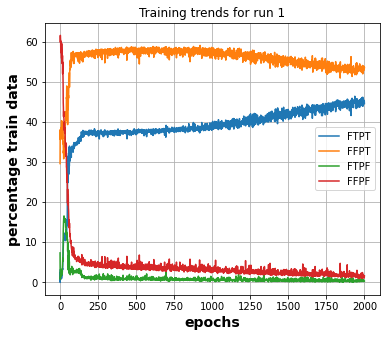

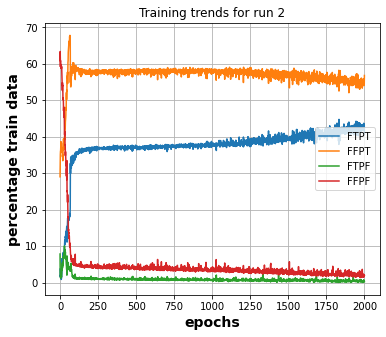

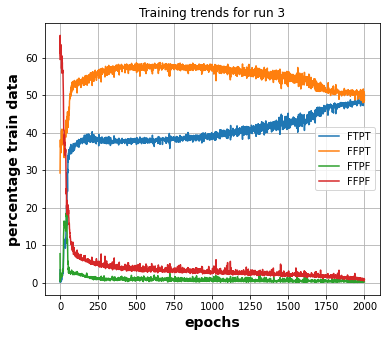

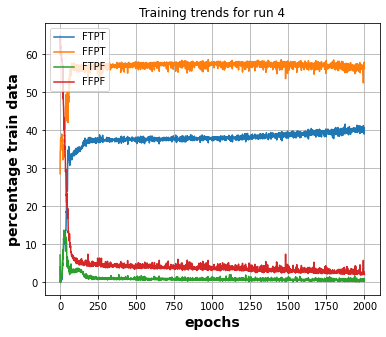

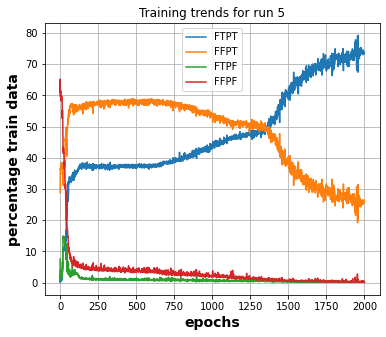

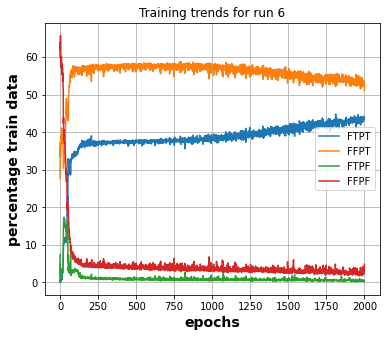

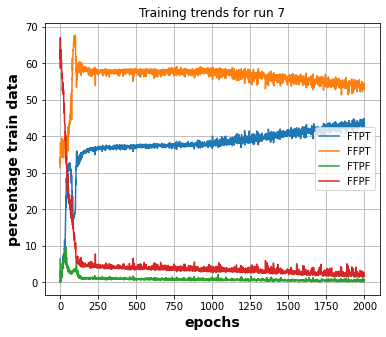

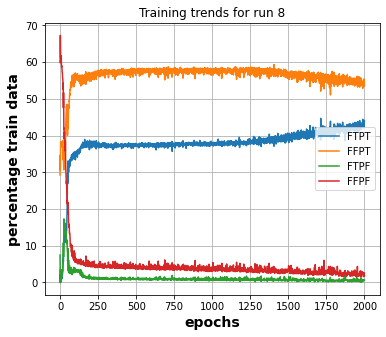

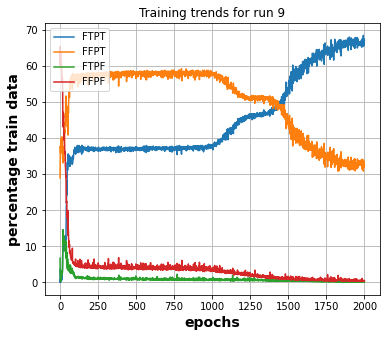

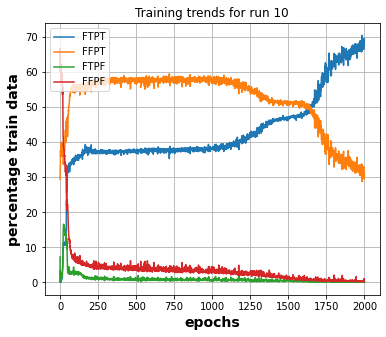

In [27]:
cnt=1
for epoch, analysis_data in full_analysis:
  analysis_data = np.array(analysis_data)
  # print("="*20+"run ",cnt,"="*20)
  
  plt.figure(figsize=(6,5))
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,0]/30,label="FTPT")
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,1]/30,label="FFPT")
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,2]/30,label="FTPF")
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,3]/30,label="FFPF")

  plt.title("Training trends for run "+str(cnt))
  plt.grid()
  # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.legend()
  plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
  plt.ylabel("percentage train data", fontsize=14, fontweight = 'bold')
  plt.savefig(path + "run"+str(cnt)+".png",bbox_inches="tight")
  plt.savefig(path + "run"+str(cnt)+".pdf",bbox_inches="tight")
  cnt+=1

In [28]:
FTPT_analysis.to_csv(path+"synthetic_zeroth.csv",index=False)